In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import ast
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm  # Para barras de progreso en notebook
import time  # Para estimar tiempos

2025-05-23 23:07:46.718979: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-23 23:07:46.762573: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-23 23:07:46.762602: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-23 23:07:46.764166: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-23 23:07:46.771952: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# Verificar que TensorFlow ve la GPU correcta
physical_devices = tf.config.list_physical_devices('GPU')
print(f"GPUs disponibles para TensorFlow: {len(physical_devices)}")
print(physical_devices)

GPUs disponibles para TensorFlow: 1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Configurar memoria de GPU para crecimiento dinámico
if physical_devices:
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memoria GPU configurada para crecimiento dinámico")
    except RuntimeError as e:
        print(f"Error al configurar memoria GPU: {e}")

Memoria GPU configurada para crecimiento dinámico


In [5]:
import joblib

# Cargar los datos guardados
all_datasets = joblib.load('all_datasets.pkl')
df = joblib.load('df_orders.pkl')

In [ ]:
# Cargar el dataset procesado con vectores de ingredientes
# Formato esperado: FF_CUSTOMER_ID, orders (donde orders es una lista de listas de vectores de ingredientes)
# Cargar el CSV
df = pd.read_csv("clientes_vectores_binarios.csv")

# Inicializar tqdm para la columna 'orders'
tqdm.pandas(desc="Procesando orders")

# Aplicar ast.literal_eval con barra de progreso
df['orders'] = df['orders'].progress_apply(ast.literal_eval)

In [ ]:
# Crear secuencias para entrenamiento
def create_sequences(data, window_size):
    X, y = [], []
    for sequence in data:
        if len(sequence) <= window_size:
            continue
        for i in range(len(sequence) - window_size):
            X.append(sequence[i:i+window_size])
            y.append(sequence[i+window_size])
    return np.array(X), np.array(y)


In [ ]:
# Preparar los datos para cada ventana temporal
window_sizes = [3, 4, 5]
all_datasets = {}

print("Generando secuencias para diferentes tamaños de ventana...")
for window in tqdm(window_sizes, desc="Preparando ventanas temporales"):
    X, y = create_sequences(df['orders'], window)
    # Dividir en Train (60%), Validation (20%), Test (20%)
    X_train_full, X_temp, y_train_full, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    all_datasets[window] = {
        'train_full': (X_train_full, y_train_full),  # 60%
        'val': (X_val, y_val),              # 20%
        'test': (X_test, y_test)            # 20%
    }
    print(f"Ventana {window}: X_train_shape={X_train_full.shape}, y_train_shape={y_train_full.shape}")


In [6]:
# Definir configuraciones de hiperparámetros a probar
hyperparameter_configs = [
    # window_size, num_layers, units_per_layer, dropout_rate, learning_rate, epochs, batch_size
    (3, 2, 128, 0.2, 1e-3, 20, 128),
    (3, 3, 128, 0.3, 1e-3, 20, 128),
    (3, 4, 128, 0.3, 1e-3, 20, 128),
    (3, 5, 128, 0.4, 1e-3, 20, 128),
    
    (4, 2, 128, 0.2, 1e-3, 20, 128),
    (4, 3, 128, 0.3, 1e-3, 20, 128),
    (4, 4, 128, 0.3, 1e-3, 20, 128),
    (4, 5, 128, 0.4, 1e-3, 20, 128),
    
    (5, 2, 128, 0.2, 1e-3, 20, 128),
    (5, 3, 128, 0.3, 1e-3, 20, 128),
    (5, 4, 128, 0.3, 1e-3, 20, 128),
    (5, 5, 128, 0.4, 1e-3, 20, 128),
    
    # También puedes variar el número de unidades
    (4, 3, 256, 0.3, 1e-3, 20, 128),
    (5, 4, 256, 0.3, 1e-3, 20, 128),
]


In [7]:
# Clase para personalizar TqdmCallback para mostrar barras de progreso durante entrenamiento
class TqdmProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs, verbose=1):
        super(TqdmProgressCallback, self).__init__()
        self.epochs = epochs
        self.verbose = verbose
        
    def on_train_begin(self, logs=None):
        self.train_progress_bar = tqdm(total=self.epochs, desc="Entrenamiento", position=0)
        
    def on_epoch_end(self, epoch, logs=None):
        self.train_progress_bar.update(1)
        if self.verbose == 1:
            # Mostrar métricas clave
            desc = f"Epoch {epoch+1}/{self.epochs}"
            if logs.get('loss'):
                desc += f" - loss: {logs['loss']:.4f}"
            if logs.get('accuracy'):
                desc += f" - acc: {logs['accuracy']:.4f}"
            if logs.get('val_loss'):
                desc += f" - val_loss: {logs['val_loss']:.4f}"
            if logs.get('val_accuracy'):
                desc += f" - val_acc: {logs['val_accuracy']:.4f}"
            self.train_progress_bar.set_description(desc)
        
    def on_train_end(self, logs=None):
        self.train_progress_bar.close()


In [8]:
# Función para construir y entrenar el modelo con hiperparámetros específicos
def build_and_train_model(window_size, num_layers, units_per_layer, dropout_rate, 
                         learning_rate, epochs, batch_size):
    # Obtener los datos para esta ventana
    X_train_full, y_train_full = all_datasets[window_size]['train_full']
    X_val, y_val = all_datasets[window_size]['val']

    # Convertir datos a float32 para evitar errores de tipo en la GPU
    X_train_full = X_train_full.astype('float32')
    y_train_full = y_train_full.astype('float32')
    X_val = X_val.astype('float32')
    y_val = y_val.astype('float32')
    
    print(f"\nConstruyendo modelo: ventana={window_size}, capas={num_layers}, unidades={units_per_layer}")
    
    # Construir el modelo
    model = Sequential()
    
    # Añadir capas LSTM según el número especificado
    for i in range(num_layers):
        return_seq = i < num_layers - 1
        if i == 0:
            model.add(LSTM(units_per_layer, return_sequences=return_seq, 
                          input_shape=(window_size, X_train_full.shape[2])))
        else:
            model.add(LSTM(units_per_layer, return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    
    # Capa de salida
    model.add(Dense(X_train_full.shape[2], activation='sigmoid'))
    
    # Compilar modelo
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Resumen del modelo
    model.summary()
    
    # Crear directorio para checkpoints si no existe
    import os
    checkpoint_dir = "checkpoints"
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    # Definir callbacks para entrenamientos persistentes
    callbacks = [
        # Early stopping para evitar sobreajuste
        EarlyStopping(monitor='val_loss', patience=3),
        
        # Checkpoint para guardar el mejor modelo según precisión de validación
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f"{checkpoint_dir}/model_window{window_size}_layers{num_layers}_units{units_per_layer}.h5",
            save_best_only=True,
            monitor='val_accuracy',
            mode='max',
            verbose=1
        ),
        
        # Guardar logs para TensorBoard
        tf.keras.callbacks.TensorBoard(
            log_dir=f"logs/fit_window{window_size}_layers{num_layers}_units{units_per_layer}",
            histogram_freq=1
        ),
        
        # Reducir tasa de aprendizaje cuando el entrenamiento se estanca
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-6,
            verbose=1
        ),
        
        # Barra de progreso tqdm para seguimiento visual
        TqdmProgressCallback(epochs=epochs, verbose=1)
    ]
    
    # Entrenar modelo
    start_time = time.time()
    history = model.fit(
        X_train_full, y_train_full,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=0  # Configurar a 0 porque usamos tqdm para mostrar progreso
    )
    training_time = time.time() - start_time
    
    # Evaluar modelo
    print("\nEvaluando modelo en conjunto de validación...")
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    
    print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")
    print(f"Pérdida de validación: {val_loss:.4f}")
    print(f"Precisión de validación: {val_accuracy:.4f}")
    
    return model, history, val_loss, val_accuracy


In [9]:
# Ejecutar la búsqueda de hiperparámetros manual
results = []

print("\n=============================================")
print("Iniciando búsqueda de hiperparámetros manual:")
print("=============================================")

start_time_total = time.time()


Iniciando búsqueda de hiperparámetros manual:


In [10]:
import tensorflow as tf

def check_device_environment():
    print("📦 TensorFlow version:", tf.__version__)
    
    # Verificar si hay GPUs disponibles
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"✅ GPUs detectadas: {len(gpus)}")
        for i, gpu in enumerate(gpus):
            try:
                details = tf.config.experimental.get_device_details(gpu)
                name = details.get('device_name', 'Desconocido')
                print(f"  - GPU {i}: {name}")
                
                # Mostrar memoria disponible si es posible
                mem_info = tf.config.experimental.get_memory_info(gpu.name)
                total_mem = mem_info.get('current', 'N/A')
                print(f"    Memoria utilizada: {total_mem / (1024**3):.2f} GB")
                
            except Exception as e:
                print(f"  - GPU {i}: No se pudo obtener detalles ({e})")
    else:
        print("⚠️ No se detectaron GPUs. El entrenamiento se realizará en CPU.")
    
    # Verificar dispositivo lógico actual
    logical_devices = tf.config.list_logical_devices()
    print("\n🔧 Dispositivos lógicos disponibles:")
    for device in logical_devices:
        print(f"  - {device.name} ({device.device_type})")

check_device_environment()


📦 TensorFlow version: 2.15.0
✅ GPUs detectadas: 1
  - GPU 0: NVIDIA A40
  - GPU 0: No se pudo obtener detalles (Failed parsing device name: '/physical_device:GPU:0'. Note a valid device string should at least contain a device type and a device index, like "GPU:0".)

🔧 Dispositivos lógicos disponibles:
  - /device:CPU:0 (CPU)
  - /device:GPU:0 (GPU)


2025-05-23 23:09:42.993254: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43713 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:ca:00.0, compute capability: 8.6


In [11]:
import gc

# Mostrar barra de progreso global para la búsqueda de hiperparámetros
for i, config in enumerate(tqdm(hyperparameter_configs, desc="Búsqueda de hiperparámetros")):
    window_size, num_layers, units, dropout, lr, epochs, batch_size = config
    
    print(f"\n[Configuración {i+1}/{len(hyperparameter_configs)}]")
    print(f"Ventana: {window_size}, Capas: {num_layers}, Unidades: {units}, Dropout: {dropout}, LR: {lr}")
    
    model, history, val_loss, val_accuracy = build_and_train_model(
        window_size, num_layers, units, dropout, lr, epochs, batch_size
    )
    
    results.append({
        'config': config,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'model': model
    })


    # Limpieza para liberar memoria GPU
    del model
    tf.keras.backend.clear_session()
    gc.collect()

total_time = time.time() - start_time_total
hours, remainder = divmod(total_time, 3600)
minutes, seconds = divmod(remainder, 60)

print("\n===============================")
print("Resumen de búsqueda completada:")
print("===============================")
print(f"Tiempo total: {int(hours)}h {int(minutes)}m {int(seconds)}s")


Búsqueda de hiperparámetros:   0%|          | 0/14 [00:00<?, ?it/s]


[Configuración 1/14]
Ventana: 3, Capas: 2, Unidades: 128, Dropout: 0.2, LR: 0.001

Construyendo modelo: ventana=3, capas=2, unidades=128


2025-05-23 23:10:03.344365: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 128)            241152    
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 342)               44118     
                                                                 
Total params: 416854 (1.59 MB)
Trainable params: 416854 (1.59 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenamiento:   0%|          | 0/20 [00:00<?, ?it/s]

2025-05-23 23:10:19.613141: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-05-23 23:10:21.007199: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f105cc5dd80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-23 23:10:21.007231: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2025-05-23 23:10:21.034853: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748041821.155379 1182593 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_accuracy improved from -inf to 0.03121, saving model to checkpoints/model_window3_layers2_units128.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy did not improve from 0.03121

Epoch 3: val_accuracy improved from 0.03121 to 0.04050, saving model to checkpoints/model_window3_layers2_units128.h5

Epoch 4: val_accuracy did not improve from 0.04050

Epoch 5: val_accuracy improved from 0.04050 to 0.04077, saving model to checkpoints/model_window3_layers2_units128.h5

Epoch 6: val_accuracy did not improve from 0.04077

Epoch 7: val_accuracy did not improve from 0.04077

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 8: val_accuracy improved from 0.04077 to 0.04159, saving model to checkpoints/model_window3_layers2_units128.h5

Epoch 9: val_accuracy did not improve from 0.04159

Epoch 10: val_accuracy did not improve from 0.04159

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 11: val_accuracy did not improve from 0.04159

Epoch 12: val_accuracy did not improve from 0.04159

Epoch 12: ReduceLROnPlateau reducing learning rate to 8.0000005254

Entrenamiento:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1: val_accuracy improved from -inf to 0.03398, saving model to checkpoints/model_window3_layers3_units128.h5

Epoch 2: val_accuracy improved from 0.03398 to 0.04317, saving model to checkpoints/model_window3_layers3_units128.h5

Epoch 3: val_accuracy did not improve from 0.04317

Epoch 4: val_accuracy did not improve from 0.04317

Epoch 5: val_accuracy improved from 0.04317 to 0.04407, saving model to checkpoints/model_window3_layers3_units128.h5

Epoch 6: val_accuracy did not improve from 0.04407

Epoch 7: val_accuracy did not improve from 0.04407

Epoch 8: val_accuracy did not improve from 0.04407

Epoch 9: val_accuracy did not improve from 0.04407

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 10: val_accuracy did not improve from 0.04407

Epoch 11: val_accuracy did not improve from 0.04407

Epoch 12: val_accuracy did not improve from 0.04407

Epoch 12: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 13: val_acc

Entrenamiento:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1: val_accuracy improved from -inf to 0.02096, saving model to checkpoints/model_window3_layers4_units128.h5

Epoch 2: val_accuracy improved from 0.02096 to 0.03103, saving model to checkpoints/model_window3_layers4_units128.h5

Epoch 3: val_accuracy improved from 0.03103 to 0.04410, saving model to checkpoints/model_window3_layers4_units128.h5

Epoch 4: val_accuracy did not improve from 0.04410

Epoch 5: val_accuracy did not improve from 0.04410

Epoch 6: val_accuracy did not improve from 0.04410

Epoch 7: val_accuracy did not improve from 0.04410

Epoch 8: val_accuracy did not improve from 0.04410

Epoch 9: val_accuracy did not improve from 0.04410

Epoch 10: val_accuracy did not improve from 0.04410

Epoch 11: val_accuracy did not improve from 0.04410

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 12: val_accuracy did not improve from 0.04410

Epoch 13: val_accuracy did not improve from 0.04410

Epoch 14: val_accuracy did not improve fro

Entrenamiento:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1: val_accuracy improved from -inf to 0.02573, saving model to checkpoints/model_window3_layers5_units128.h5

Epoch 2: val_accuracy improved from 0.02573 to 0.03046, saving model to checkpoints/model_window3_layers5_units128.h5

Epoch 3: val_accuracy improved from 0.03046 to 0.03503, saving model to checkpoints/model_window3_layers5_units128.h5

Epoch 4: val_accuracy did not improve from 0.03503

Epoch 5: val_accuracy improved from 0.03503 to 0.03505, saving model to checkpoints/model_window3_layers5_units128.h5

Epoch 6: val_accuracy improved from 0.03505 to 0.04862, saving model to checkpoints/model_window3_layers5_units128.h5

Epoch 7: val_accuracy did not improve from 0.04862

Epoch 8: val_accuracy did not improve from 0.04862

Epoch 9: val_accuracy did not improve from 0.04862

Epoch 10: val_accuracy did not improve from 0.04862

Epoch 11: val_accuracy did not improve from 0.04862

Epoch 12: val_accuracy did not improve from 0.04862

Epoch 13: val_accuracy did not improve f

Entrenamiento:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1: val_accuracy improved from -inf to 0.04810, saving model to checkpoints/model_window4_layers2_units128.h5

Epoch 2: val_accuracy did not improve from 0.04810

Epoch 3: val_accuracy did not improve from 0.04810

Epoch 4: val_accuracy did not improve from 0.04810

Epoch 5: val_accuracy did not improve from 0.04810

Epoch 6: val_accuracy did not improve from 0.04810

Epoch 7: val_accuracy did not improve from 0.04810

Epoch 8: val_accuracy did not improve from 0.04810

Epoch 9: val_accuracy did not improve from 0.04810

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 10: val_accuracy did not improve from 0.04810

Epoch 11: val_accuracy did not improve from 0.04810

Epoch 12: val_accuracy did not improve from 0.04810

Epoch 12: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 13: val_accuracy did not improve from 0.04810

Epoch 14: val_accuracy did not improve from 0.04810

Epoch 14: ReduceLROnPlateau reducing learning

Entrenamiento:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1: val_accuracy improved from -inf to 0.03143, saving model to checkpoints/model_window4_layers3_units128.h5

Epoch 2: val_accuracy did not improve from 0.03143

Epoch 3: val_accuracy improved from 0.03143 to 0.04778, saving model to checkpoints/model_window4_layers3_units128.h5

Epoch 4: val_accuracy did not improve from 0.04778

Epoch 5: val_accuracy did not improve from 0.04778

Epoch 6: val_accuracy did not improve from 0.04778

Epoch 7: val_accuracy did not improve from 0.04778

Epoch 8: val_accuracy did not improve from 0.04778

Epoch 9: val_accuracy did not improve from 0.04778

Epoch 10: val_accuracy did not improve from 0.04778

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 11: val_accuracy did not improve from 0.04778

Epoch 12: val_accuracy did not improve from 0.04778

Epoch 13: val_accuracy did not improve from 0.04778

Epoch 13: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 14: val_accuracy did not

Entrenamiento:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1: val_accuracy improved from -inf to 0.03822, saving model to checkpoints/model_window4_layers4_units128.h5

Epoch 2: val_accuracy did not improve from 0.03822

Epoch 3: val_accuracy did not improve from 0.03822

Epoch 4: val_accuracy improved from 0.03822 to 0.04901, saving model to checkpoints/model_window4_layers4_units128.h5

Epoch 5: val_accuracy did not improve from 0.04901

Epoch 6: val_accuracy did not improve from 0.04901

Epoch 7: val_accuracy did not improve from 0.04901

Epoch 8: val_accuracy improved from 0.04901 to 0.05320, saving model to checkpoints/model_window4_layers4_units128.h5

Epoch 9: val_accuracy did not improve from 0.05320

Epoch 10: val_accuracy did not improve from 0.05320

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 11: val_accuracy did not improve from 0.05320

Epoch 12: val_accuracy did not improve from 0.05320

Epoch 13: val_accuracy did not improve from 0.05320

Epoch 13: ReduceLROnPlateau reducing learn

Entrenamiento:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1: val_accuracy improved from -inf to 0.02340, saving model to checkpoints/model_window4_layers5_units128.h5

Epoch 2: val_accuracy improved from 0.02340 to 0.02938, saving model to checkpoints/model_window4_layers5_units128.h5

Epoch 3: val_accuracy improved from 0.02938 to 0.03131, saving model to checkpoints/model_window4_layers5_units128.h5

Epoch 4: val_accuracy did not improve from 0.03131

Epoch 5: val_accuracy improved from 0.03131 to 0.03165, saving model to checkpoints/model_window4_layers5_units128.h5

Epoch 6: val_accuracy improved from 0.03165 to 0.03187, saving model to checkpoints/model_window4_layers5_units128.h5

Epoch 7: val_accuracy did not improve from 0.03187

Epoch 8: val_accuracy improved from 0.03187 to 0.03582, saving model to checkpoints/model_window4_layers5_units128.h5

Epoch 9: val_accuracy did not improve from 0.03582

Epoch 10: val_accuracy did not improve from 0.03582

Epoch 11: val_accuracy did not improve from 0.03582

Epoch 12: val_accuracy did

Entrenamiento:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1: val_accuracy improved from -inf to 0.03439, saving model to checkpoints/model_window5_layers2_units128.h5

Epoch 2: val_accuracy improved from 0.03439 to 0.04143, saving model to checkpoints/model_window5_layers2_units128.h5

Epoch 3: val_accuracy did not improve from 0.04143

Epoch 4: val_accuracy improved from 0.04143 to 0.05596, saving model to checkpoints/model_window5_layers2_units128.h5

Epoch 5: val_accuracy did not improve from 0.05596

Epoch 6: val_accuracy did not improve from 0.05596

Epoch 7: val_accuracy did not improve from 0.05596

Epoch 8: val_accuracy did not improve from 0.05596

Epoch 9: val_accuracy did not improve from 0.05596

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 10: val_accuracy did not improve from 0.05596

Epoch 11: val_accuracy did not improve from 0.05596

Epoch 12: val_accuracy did not improve from 0.05596

Epoch 12: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 13: val_acc

Entrenamiento:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1: val_accuracy improved from -inf to 0.03357, saving model to checkpoints/model_window5_layers3_units128.h5

Epoch 2: val_accuracy improved from 0.03357 to 0.04336, saving model to checkpoints/model_window5_layers3_units128.h5

Epoch 3: val_accuracy did not improve from 0.04336

Epoch 4: val_accuracy did not improve from 0.04336

Epoch 5: val_accuracy did not improve from 0.04336

Epoch 6: val_accuracy did not improve from 0.04336

Epoch 7: val_accuracy did not improve from 0.04336

Epoch 8: val_accuracy did not improve from 0.04336

Epoch 9: val_accuracy did not improve from 0.04336

Epoch 10: val_accuracy did not improve from 0.04336

Epoch 11: val_accuracy did not improve from 0.04336

Epoch 12: val_accuracy did not improve from 0.04336

Epoch 13: val_accuracy did not improve from 0.04336

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 14: val_accuracy did not improve from 0.04336

Epoch 15: val_accuracy did not improve from 0.04336

Epo

Entrenamiento:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1: val_accuracy improved from -inf to 0.02017, saving model to checkpoints/model_window5_layers4_units128.h5

Epoch 2: val_accuracy improved from 0.02017 to 0.02287, saving model to checkpoints/model_window5_layers4_units128.h5

Epoch 3: val_accuracy improved from 0.02287 to 0.04523, saving model to checkpoints/model_window5_layers4_units128.h5

Epoch 4: val_accuracy did not improve from 0.04523

Epoch 5: val_accuracy did not improve from 0.04523

Epoch 6: val_accuracy did not improve from 0.04523

Epoch 7: val_accuracy did not improve from 0.04523

Epoch 8: val_accuracy did not improve from 0.04523

Epoch 9: val_accuracy improved from 0.04523 to 0.04960, saving model to checkpoints/model_window5_layers4_units128.h5

Epoch 10: val_accuracy did not improve from 0.04960

Epoch 11: val_accuracy did not improve from 0.04960

Epoch 12: val_accuracy did not improve from 0.04960

Epoch 13: val_accuracy did not improve from 0.04960

Epoch 14: val_accuracy did not improve from 0.04960

E

Entrenamiento:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1: val_accuracy improved from -inf to 0.02676, saving model to checkpoints/model_window5_layers5_units128.h5

Epoch 2: val_accuracy did not improve from 0.02676

Epoch 3: val_accuracy did not improve from 0.02676

Epoch 4: val_accuracy did not improve from 0.02676

Epoch 5: val_accuracy improved from 0.02676 to 0.03821, saving model to checkpoints/model_window5_layers5_units128.h5

Epoch 6: val_accuracy did not improve from 0.03821

Epoch 7: val_accuracy did not improve from 0.03821

Epoch 8: val_accuracy did not improve from 0.03821

Epoch 9: val_accuracy did not improve from 0.03821

Epoch 10: val_accuracy did not improve from 0.03821

Epoch 11: val_accuracy did not improve from 0.03821

Epoch 12: val_accuracy did not improve from 0.03821

Epoch 13: val_accuracy did not improve from 0.03821

Epoch 14: val_accuracy did not improve from 0.03821

Epoch 15: val_accuracy did not improve from 0.03821

Epoch 16: val_accuracy did not improve from 0.03821

Epoch 17: val_accuracy did no

Entrenamiento:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1: val_accuracy improved from -inf to 0.04182, saving model to checkpoints/model_window4_layers3_units256.h5

Epoch 2: val_accuracy improved from 0.04182 to 0.04373, saving model to checkpoints/model_window4_layers3_units256.h5

Epoch 3: val_accuracy did not improve from 0.04373

Epoch 4: val_accuracy did not improve from 0.04373

Epoch 5: val_accuracy did not improve from 0.04373

Epoch 6: val_accuracy did not improve from 0.04373

Epoch 7: val_accuracy did not improve from 0.04373

Epoch 8: val_accuracy did not improve from 0.04373

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 9: val_accuracy did not improve from 0.04373

Epoch 10: val_accuracy did not improve from 0.04373

Epoch 11: val_accuracy did not improve from 0.04373

Epoch 11: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 12: val_accuracy did not improve from 0.04373

Evaluando modelo en conjunto de validación...
12088/12088 [=========================

Entrenamiento:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1: val_accuracy improved from -inf to 0.03502, saving model to checkpoints/model_window5_layers4_units256.h5

Epoch 2: val_accuracy did not improve from 0.03502

Epoch 3: val_accuracy improved from 0.03502 to 0.04525, saving model to checkpoints/model_window5_layers4_units256.h5

Epoch 4: val_accuracy did not improve from 0.04525

Epoch 5: val_accuracy did not improve from 0.04525

Epoch 6: val_accuracy did not improve from 0.04525

Epoch 7: val_accuracy did not improve from 0.04525

Epoch 8: val_accuracy improved from 0.04525 to 0.05028, saving model to checkpoints/model_window5_layers4_units256.h5

Epoch 9: val_accuracy did not improve from 0.05028

Epoch 10: val_accuracy did not improve from 0.05028

Epoch 11: val_accuracy did not improve from 0.05028

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 12: val_accuracy did not improve from 0.05028

Epoch 13: val_accuracy did not improve from 0.05028

Epoch 14: val_accuracy did not improve fro

In [12]:
# Mostrar resultados en una tabla
print("\nResultados ordenados por precisión de validación:")
print("{:<5} {:<10} {:<10} {:<10} {:<10} {:<15} {:<15}".format(
    "ID", "Ventana", "Capas", "Unidades", "Dropout", "Val Loss", "Val Accuracy"))
print("-" * 80)



Resultados ordenados por precisión de validación:
ID    Ventana    Capas      Unidades   Dropout    Val Loss        Val Accuracy   
--------------------------------------------------------------------------------


In [13]:
# Ordenar resultados por precisión de validación (mayor a menor)
sorted_results = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)

for i, result in enumerate(sorted_results):
    config = result['config']
    print("{:<5} {:<10} {:<10} {:<10} {:<10} {:<15.4f} {:<15.4f}".format(
        i+1, config[0], config[1], config[2], config[3], result['val_loss'], result['val_accuracy']))


1     5          4          256        0.3        0.0964          0.0439         
2     3          4          128        0.3        0.1002          0.0419         
3     4          3          256        0.3        0.0979          0.0417         
4     4          2          128        0.2        0.0978          0.0410         
5     3          3          128        0.3        0.1002          0.0406         
6     3          2          128        0.2        0.1001          0.0401         
7     5          4          128        0.3        0.0964          0.0384         
8     5          2          128        0.2        0.0963          0.0382         
9     5          3          128        0.3        0.0964          0.0381         
10    4          5          128        0.4        0.0984          0.0371         
11    4          4          128        0.3        0.0980          0.0366         
12    4          3          128        0.3        0.0979          0.0356         
13    5         

In [14]:
# Encontrar la mejor configuración basada en precisión de validación
best_result = sorted_results[0]
best_config = best_result['config']
best_model = best_result['model']

print("\n============================")
print("Mejor configuración encontrada:")
print("============================")
print(f"- Ventana temporal: {best_config[0]}")
print(f"- Número de capas LSTM: {best_config[1]}")
print(f"- Unidades por capa: {best_config[2]}")
print(f"- Tasa de dropout: {best_config[3]}")
print(f"- Tasa de aprendizaje: {best_config[4]}")
print(f"- Épocas: {best_config[5]}")
print(f"- Tamaño de batch: {best_config[6]}")
print(f"- Precisión de validación: {best_result['val_accuracy']:.4f}")



Mejor configuración encontrada:
- Ventana temporal: 5
- Número de capas LSTM: 4
- Unidades por capa: 256
- Tasa de dropout: 0.3
- Tasa de aprendizaje: 0.001
- Épocas: 20
- Tamaño de batch: 128
- Precisión de validación: 0.0439


In [15]:
# Evaluación final en datos de prueba
print("\n============================")
print("Evaluación final en datos de prueba:")
print("============================")

window_size = best_config[0]
X_test, y_test = all_datasets[window_size]['test']

print("Evaluando modelo en conjunto de prueba...")
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)

print(f"\nResultados finales en datos de prueba:")
print(f"- Loss: {test_loss:.4f}")
print(f"- Accuracy: {test_accuracy:.4f}")


Evaluación final en datos de prueba:
Evaluando modelo en conjunto de prueba...
11281/11281 [==============================] - 80s 7ms/step - loss: 0.0964 - accuracy: 0.0437

Resultados finales en datos de prueba:
- Loss: 0.0964
- Accuracy: 0.0437


In [16]:
# Guardar el mejor modelo
model_filename = f"best_lstm_model_window{window_size}_acc{test_accuracy:.4f}.h5"
best_model.save(model_filename)
print(f"\nModelo guardado como: {model_filename}")



Modelo guardado como: best_lstm_model_window5_acc0.0437.h5


In [17]:
# Guardar resultados de la búsqueda de hiperparámetros
import json
with open('hyperparameter_search_results.json', 'w') as f:
    # Convertir resultados a formato serializable (eliminar objetos modelo)
    serializable_results = []
    for res in sorted_results:
        serializable_res = {
            'config': res['config'],
            'val_loss': float(res['val_loss']),
            'val_accuracy': float(res['val_accuracy'])
        }
        serializable_results.append(serializable_res)
    
    json.dump(serializable_results, f, indent=2)

print("Resultados de búsqueda de hiperparámetros guardados en hyperparameter_search_results.json")


Resultados de búsqueda de hiperparámetros guardados en hyperparameter_search_results.json


/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Visualización de resultados guardada en hyperparameter_search_results.png

¡Proceso de búsqueda y entrenamiento completado!


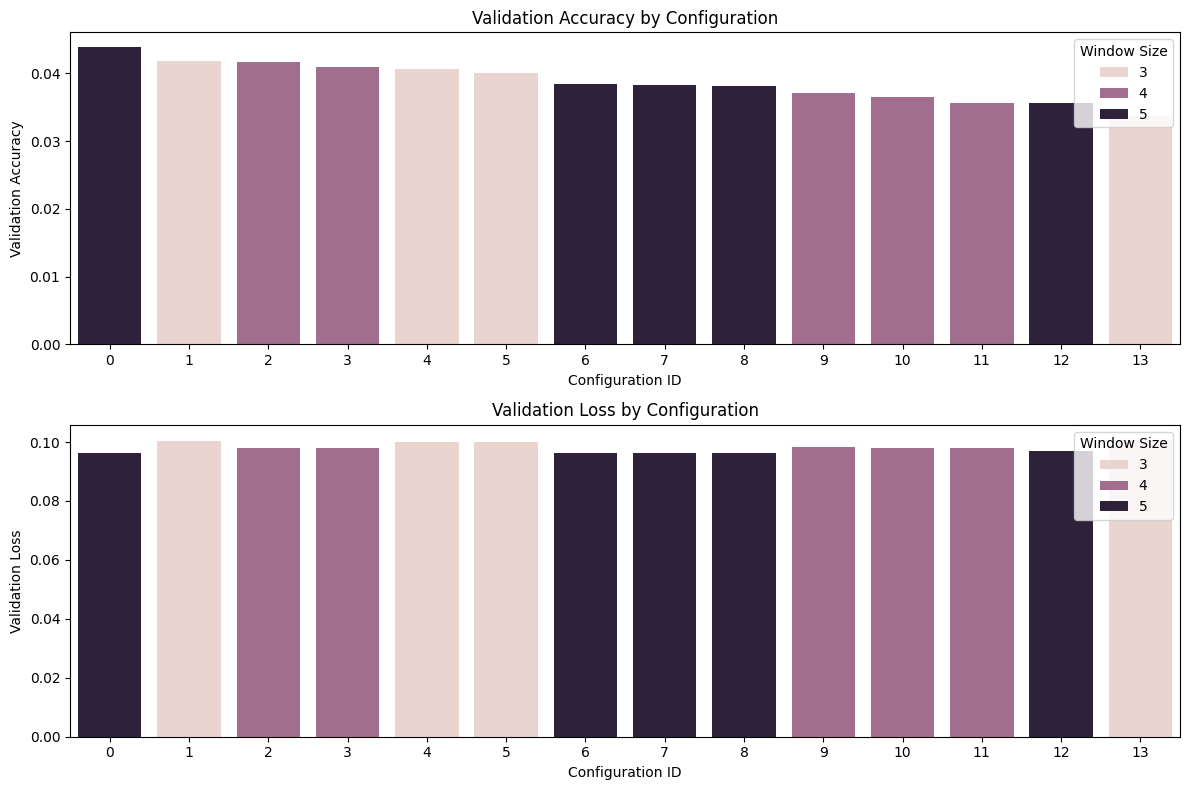

In [18]:
# Generar visualización de resultados
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(12, 8))
    
    # Extraer datos para gráficas
    window_sizes = [r['config'][0] for r in sorted_results]
    layers = [r['config'][1] for r in sorted_results]
    accuracies = [r['val_accuracy'] for r in sorted_results]
    losses = [r['val_loss'] for r in sorted_results]
    
    # Crear un DataFrame para facilitar la visualización
    viz_df = pd.DataFrame({
        'Window Size': window_sizes,
        'Layers': layers,
        'Accuracy': accuracies,
        'Loss': losses
    })
    
    # Graficar precisión por configuración
    plt.subplot(2, 1, 1)
    sns.barplot(x=range(len(sorted_results)), y='Accuracy', hue='Window Size', data=viz_df)
    plt.title('Validation Accuracy by Configuration')
    plt.xlabel('Configuration ID')
    plt.ylabel('Validation Accuracy')
    plt.legend(title='Window Size')
    
    # Graficar pérdida por configuración
    plt.subplot(2, 1, 2)
    sns.barplot(x=range(len(sorted_results)), y='Loss', hue='Window Size', data=viz_df)
    plt.title('Validation Loss by Configuration')
    plt.xlabel('Configuration ID')
    plt.ylabel('Validation Loss')
    plt.legend(title='Window Size')
    
    plt.tight_layout()
    plt.savefig('hyperparameter_search_results.png')
    print("Visualización de resultados guardada en hyperparameter_search_results.png")
except Exception as e:
    print(f"No se pudo generar la visualización: {e}")

print("\n¡Proceso de búsqueda y entrenamiento completado!")